In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import wandb # This is optional 
wandb.login(host = "https://genentech.wandb.io" )

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: zhao-yulai (grelu). Use `wandb login --relogin` to force relogin


True

## Preparation 

In [2]:
# Any numebr is fine 
DEVICE = "cuda:5"

If you wanna download a good model already, download it from W&B

In [3]:
run = wandb.init(entity ='grelu', project="Diffusion-DNA-RNA", name = "test") # Change depending on your projects
artifact = run.use_artifact('MPRA-y-HepG2-Model:v0')
dir = artifact.download()
wandb.finish()

wandb: Downloading large artifact MPRA-y-HepG2-Model:v0, 167.14MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.8


In [4]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/MPRA-dataset:v2/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    checkpoint_path = 'artifacts/MPRA-y-HepG2-Model:v0/diffusion_epoch=035.ckpt'
    time_schedule = 'artifacts/MPRA-dataset:v2/time_dependent.npz'
config = ModelParameters() 

In [5]:
score_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, time_schedule = config.time_schedule, weight_file = config.diffusion_weights_file)
score_model.cuda(device = DEVICE) 


LightningDiffusion(
  (model): ScoreNet_Conditional(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (blocks): ModuleList(
      (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
      (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
      (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
      (10-11): 

In [6]:
sampler = ddsm.Euler_Maruyama_sampler
yS = 1.0 * torch.ones(128)
yS = yS.type(torch.LongTensor)
yS = yS.to(DEVICE)

## Generate Samples with High Properties  

In [7]:
#generate sequence samples
# Condition on 1 (High Expression level)

allsamples_original_weak = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(score_model,
                        (200,4),
                        batch_size=128,
                        new_class = yS,
                        class_number = 2,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 0.9,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original_weak.append(samples)

100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


In [8]:
allsamples_weak = np.concatenate(allsamples_original_weak, axis=1)
allsamples_weak = allsamples_weak[0,:,:,:]
print(allsamples_weak.shape)

(640, 200, 4)


# Get Original Data

In [1]:
import numpy as np

data = np.load("artifacts/MPRA-dataset:v2/y_HepG2.npz")['x']
label = np.load("artifacts/MPRA-dataset:v2/y_HepG2.npz")['y'] 
valsamples = data[label == 1, :, :] # Select data with label =1 

In [5]:
print(valsamples.shape)
print(data.shape)
print(label.shape)
print(type(data))
print(type(label))

(10193, 200, 4)
(203842, 200, 4)
(203842,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Compare Generated Samples and Original Samples

In [11]:
from grelu.resources import load_model

run = wandb.init(entity ='grelu', project= 'human-mpra-gosai-2023', name = "download") # Change depending on your projects
artifact = run.use_artifact('model:v4') # This is a function from x(UTR) -> Y (transcription efficinecy)
dir = artifact.download()
wandb.finish()

wandb: Downloading large artifact model:v4, 999.24MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:25.0


In [12]:
from grelu.lightning import LightningModel
model = LightningModel.load_from_checkpoint("artifacts/model:v4/model.ckpt")
model.eval()
model.to(DEVICE)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:13.3


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [13]:
data_loader = torch.utils.data.DataLoader(valsamples.astype("float32"), batch_size = 128 , num_workers=0)
val_samples = []

for batch in data_loader:
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    val_samples.append( model(batch).detach().cpu() ) 

In [14]:
val_samples = np.concatenate(val_samples)

In [15]:
generated_samples_weak = []
data_loader = torch.utils.data.DataLoader(allsamples_weak.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_weak.append( model(batch).detach().cpu() ) 

In [16]:
generated_samples_weak = np.concatenate(generated_samples_weak)

<Figure size 8000x1000 with 0 Axes>

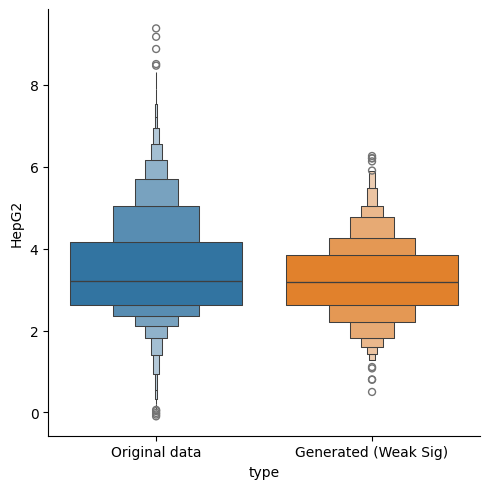

In [17]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate( (val_samples[:,0], generated_samples_weak[:,0]  ), axis= 0)

type1 = ['Original data' for i in range(len(val_samples[:,0] ))]
#type2 = ['Generated (Strong Sig)' for i in range(len(generated_samples[:,0] ))]
type3 = ['Generated (Weak Sig)' for i in range(len(generated_samples_weak[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'HepG2': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'HepG2', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/DNA_high_output.png")


# Generate normal sampels 

In [18]:
sampler = ddsm.Euler_Maruyama_sampler
yS = 2.0 * torch.ones(128)
yS = yS.type(torch.LongTensor)
yS = yS.to(DEVICE)

In [19]:
# Generate sequence samples
# Condition on 0 (low)
allsamples_original = []
for t in range(10):
    samples=[]
    score_model.eval()
    samples.append(sampler(score_model,
                        (200,4),
                        batch_size=128,
                        new_class = yS,
                        class_number = 2,
                        strength = 2, 
                        max_time=  4.0,
                        min_time= 0.9,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:06<00:00, 15.05it/s]


In [20]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]
print(allsamples.shape)

(1280, 200, 4)


In [21]:
data = np.load("artifacts/MPRA-dataset:v2/y_HepG2.npz")['x']
label = np.load("artifacts/MPRA-dataset:v2/y_HepG2.npz")['y'] 
valsamples = data[label == 0, :, :]

In [22]:
seq_gen_int = np.argmax(allsamples, axis=-1)
seq_gen_str = [''.join([['A','C','G','T'][num] for num in seq]) for seq in seq_gen_int]
gen_kmers = utils.count_kmers(seq_gen_str)
seq_val_int = np.argmax(valsamples, axis=-1)
seq_val_str = [''.join([['A','C','G','T'][num] for num in seq]) for seq in seq_val_int]
val_kmers = utils.count_kmers(seq_val_str)

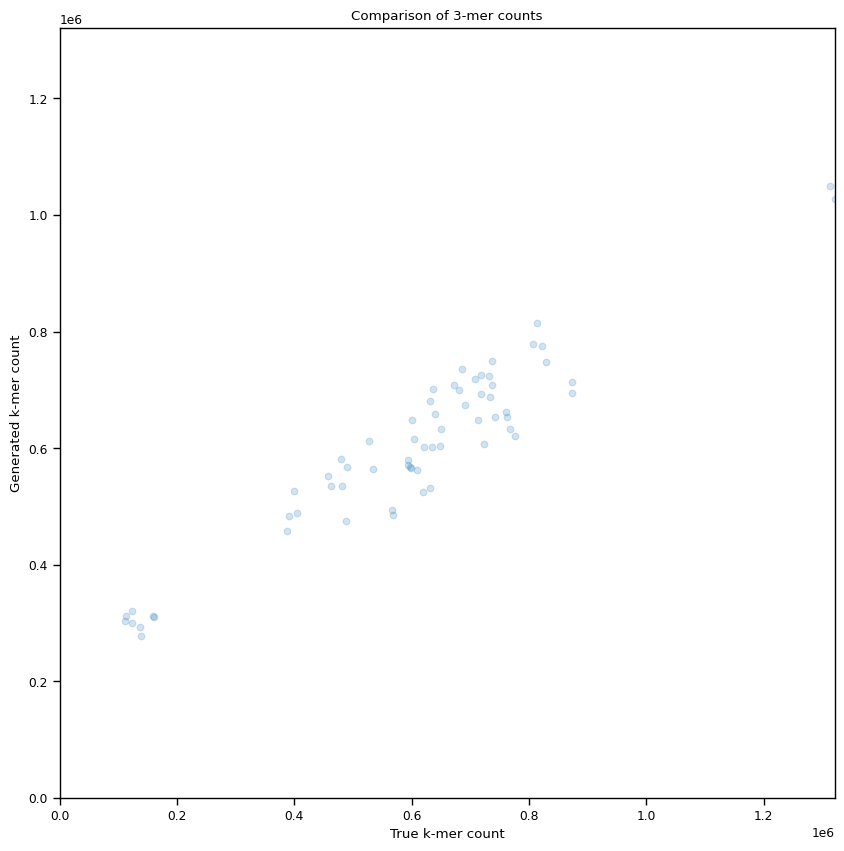

PearsonRResult(statistic=0.9538570902166412, pvalue=4.25373894497429e-34)

In [23]:
kmer_set = set(gen_kmers.keys()) | set(val_kmers.keys())
counts = np.zeros((len(kmer_set), 2))
for i, kmer in enumerate(kmer_set):
    if kmer in gen_kmers:
        counts[i][1] = gen_kmers[kmer] * valsamples.shape[0]/allsamples.shape[0]
    if kmer in val_kmers:
        counts[i][0] = val_kmers[kmer]
        
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(counts[:, 0], counts[:, 1], alpha=0.2)
ax.set_title("Comparison of 3-mer counts")
ax.set_xlabel("True k-mer count")
ax.set_ylabel("Generated k-mer count")
ax.set_ylim((-5, np.max(counts) + 5))
ax.set_xlim((-5, np.max(counts) + 5))
plt.show()

sp.stats.pearsonr(counts[:, 0], counts[:, 1])

In [24]:
generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append( model(batch).detach().cpu() ) 

In [25]:
generated_samples = np.concatenate(generated_samples)

In [26]:
model.eval()
model.to(DEVICE)
data_loader = torch.utils.data.DataLoader(valsamples.astype("float32"), batch_size = 128 , num_workers=0)
val_samples = []

for batch in data_loader:
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    val_samples.append( model(batch).detach().cpu() ) 

In [27]:
val_samples = np.concatenate(val_samples)

FileNotFoundError: [Errno 2] No such file or directory: '/raid/home/ueharam1/projects3/diffusion-dna-rna-main/tutorials/media/DNA_low_output.png'

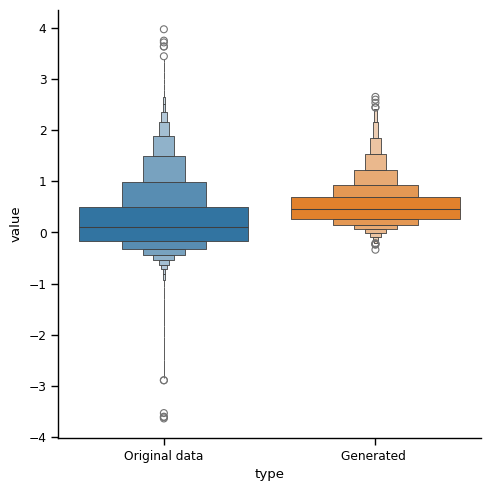

In [28]:
%matplotlib inline

compare = np.concatenate( (val_samples[:,0] ,generated_samples[:,0]   ), axis= 0)

type1 = ['Original data' for i in range(len(val_samples[:,0] ))]
type2 = ['Generated ' for i in range(len(generated_samples[:,0] ))]

type =   type1 + type2 
data_dict = {'type': type, 'value': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'value', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (20, 10)})
#fig.savefig("../../media/DNA_low_output.png")

